# Задание 1.0

## Подключаем нужные библиотеки

In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from datetime import datetime

# def dates_str_to_days(date_str: str, date0_str="21 June 2012", date_format: str="%d %B %Y") -> int:
#     date0_obj = datetime.strptime(date0_str, date_format)
#     date_obj = datetime.strptime(date_str, date_format)
#     return (date_obj-date0_obj).days


## Загружаем Dataset

In [99]:
df = pd.read_csv("d:/loan_train.csv")
df.head()
df = df.dropna()

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              499 non-null    object 
 1   Married             499 non-null    object 
 2   Dependents          499 non-null    object 
 3   Education           499 non-null    object 
 4   Self_Employed       499 non-null    object 
 5   Applicant_Income    499 non-null    int64  
 6   Coapplicant_Income  499 non-null    float64
 7   Loan_Amount         499 non-null    int64  
 8   Term                499 non-null    float64
 9   Credit_History      499 non-null    float64
 10  Area                499 non-null    object 
 11  Status              499 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 50.7+ KB


In [101]:
df.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History
count,4.990000e+02,4.990000e+02,4.990000e+02,499.000000,499.000000
mean,5.336128e+05,1.566996e+05,1.395251e+07,342.012024,0.851703
std,5.618157e+05,2.580955e+05,8.345237e+06,64.860368,0.355750
min,1.500000e+04,0.000000e+00,0.000000e+00,36.000000,0.000000
25%,2.885500e+05,0.000000e+00,9.800000e+06,360.000000,1.000000
50%,3.859000e+05,1.086000e+05,1.260000e+07,360.000000,1.000000
75%,5.825000e+05,2.251500e+05,1.665000e+07,360.000000,1.000000
max,8.100000e+06,3.383700e+06,6.000000e+07,480.000000,1.000000


In [102]:
df.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Term                  0
Credit_History        0
Area                  0
Status                0
dtype: int64

In [103]:
le = LabelEncoder()
for i, f in enumerate(df.select_dtypes(include="object")):
    le.fit(df[f])
    list(le.classes_)
    df[f] = le.fit_transform(df[f])

# Задание 1.1
Выбрать и обосновать метрику для измерения качества

Комментарий: В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи, написав краткое обоснование (1-2 предложения). 

Критерии оценки:

- Предложена метрика - 5 баллов
- Присутствует корректное обоснование - 5 баллов

Ответ: Для выполения задания был выбран дата-сет для предсказания значений. Таким образом потребуются метрики для задач регрессии: MSE & RMSE, MAE или/и MAPE. В 1.3 будут рассмтренны все, чтобы проанализовать и сравнить. В случае, если будут сильные выбросы в выборке при эксполоритарном анализе, то MSE метрика будет слишко штрафовать и не даст оценить.

# Задание 1.2

Провести EDA на своих данных

Комментарий: В рамках данного пункта необходимо провести предварительный разведочный анализ своего набора данных.

Критерии оценки:

- Рассмотрены базовые характеристики/статистики для набора данных - 2 балла
- Реализованы наиболее релевантные визуализации - 4 балла
- По ходу работы присутствуют комментарии (вы, как эксперт в предметной области, можете проинтерпретировать полученные результаты анализа, сделав выводы о том, каким образом лучше работать с набором данных в будущем, какие могут возникнуть проблемы, какую предобработку целесообразно сделать и тп) - 4 балла
- Продемонстрировать использование библиотеки plotly для визуализации

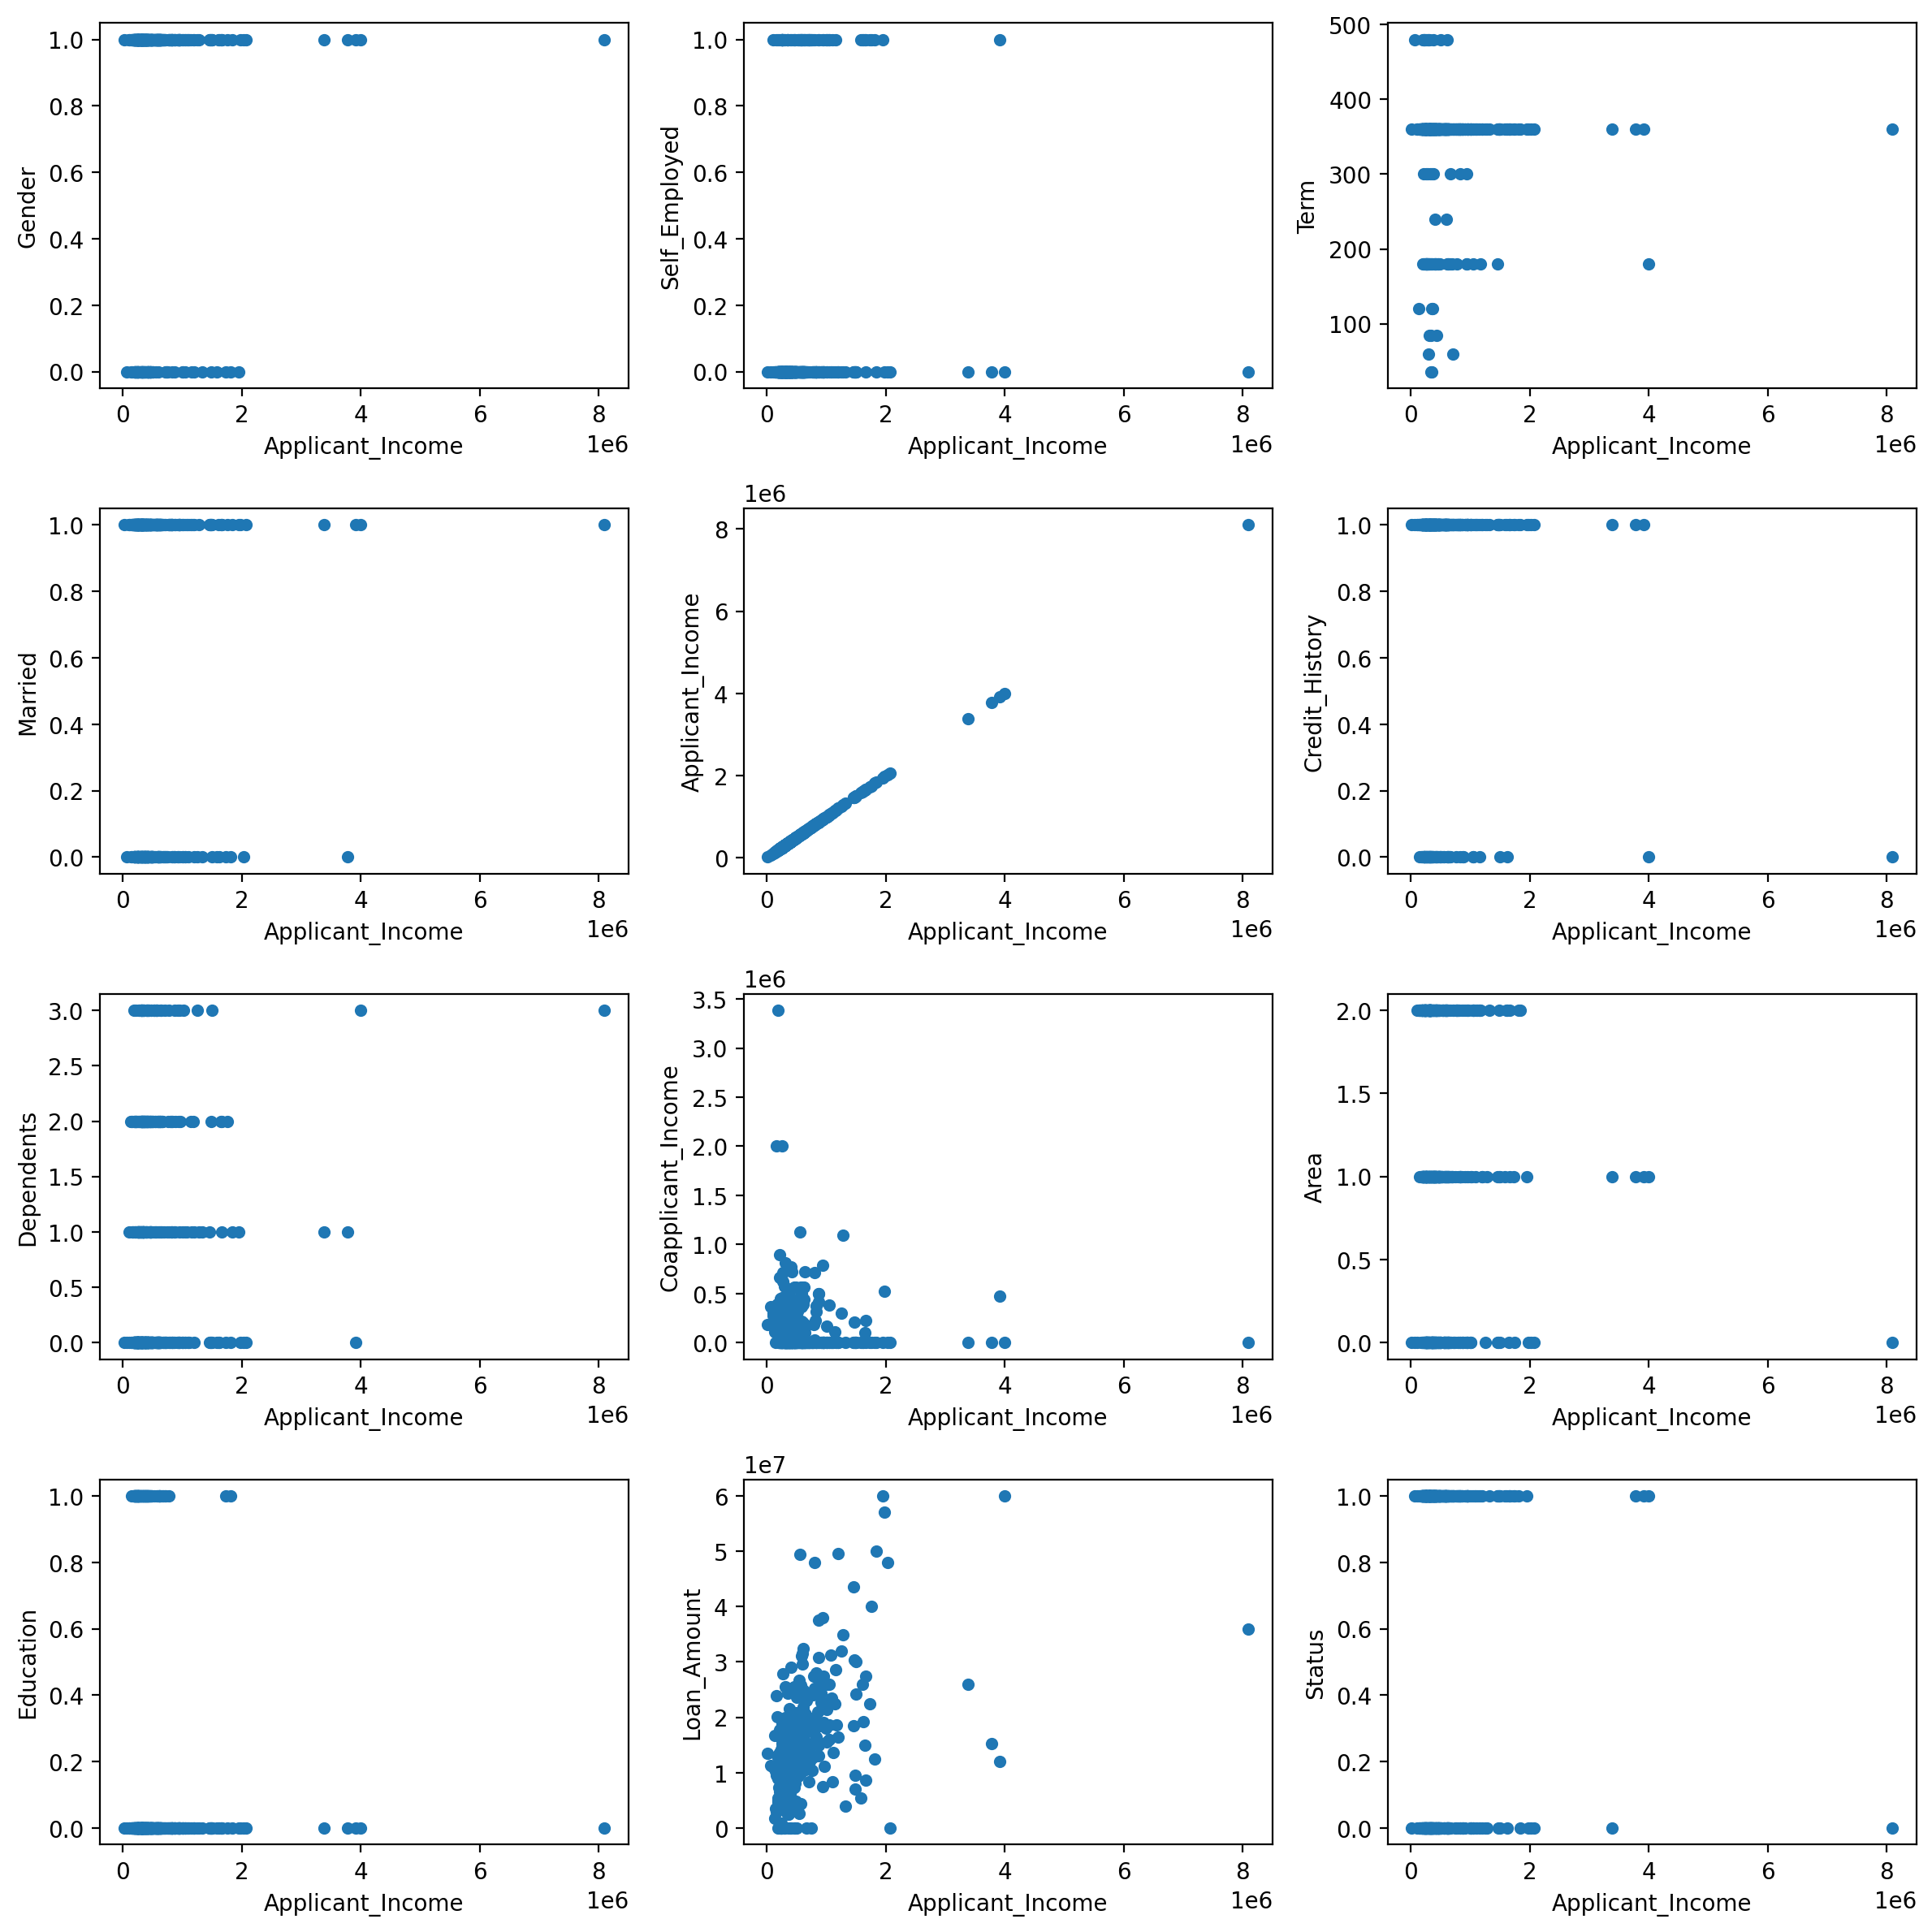

In [104]:
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=4, dpi=200)
for i, f in enumerate(df):
    df.plot("Applicant_Income", f, subplots=True, kind='scatter', ax = axes[i%4, i//4])
plt.tight_layout()

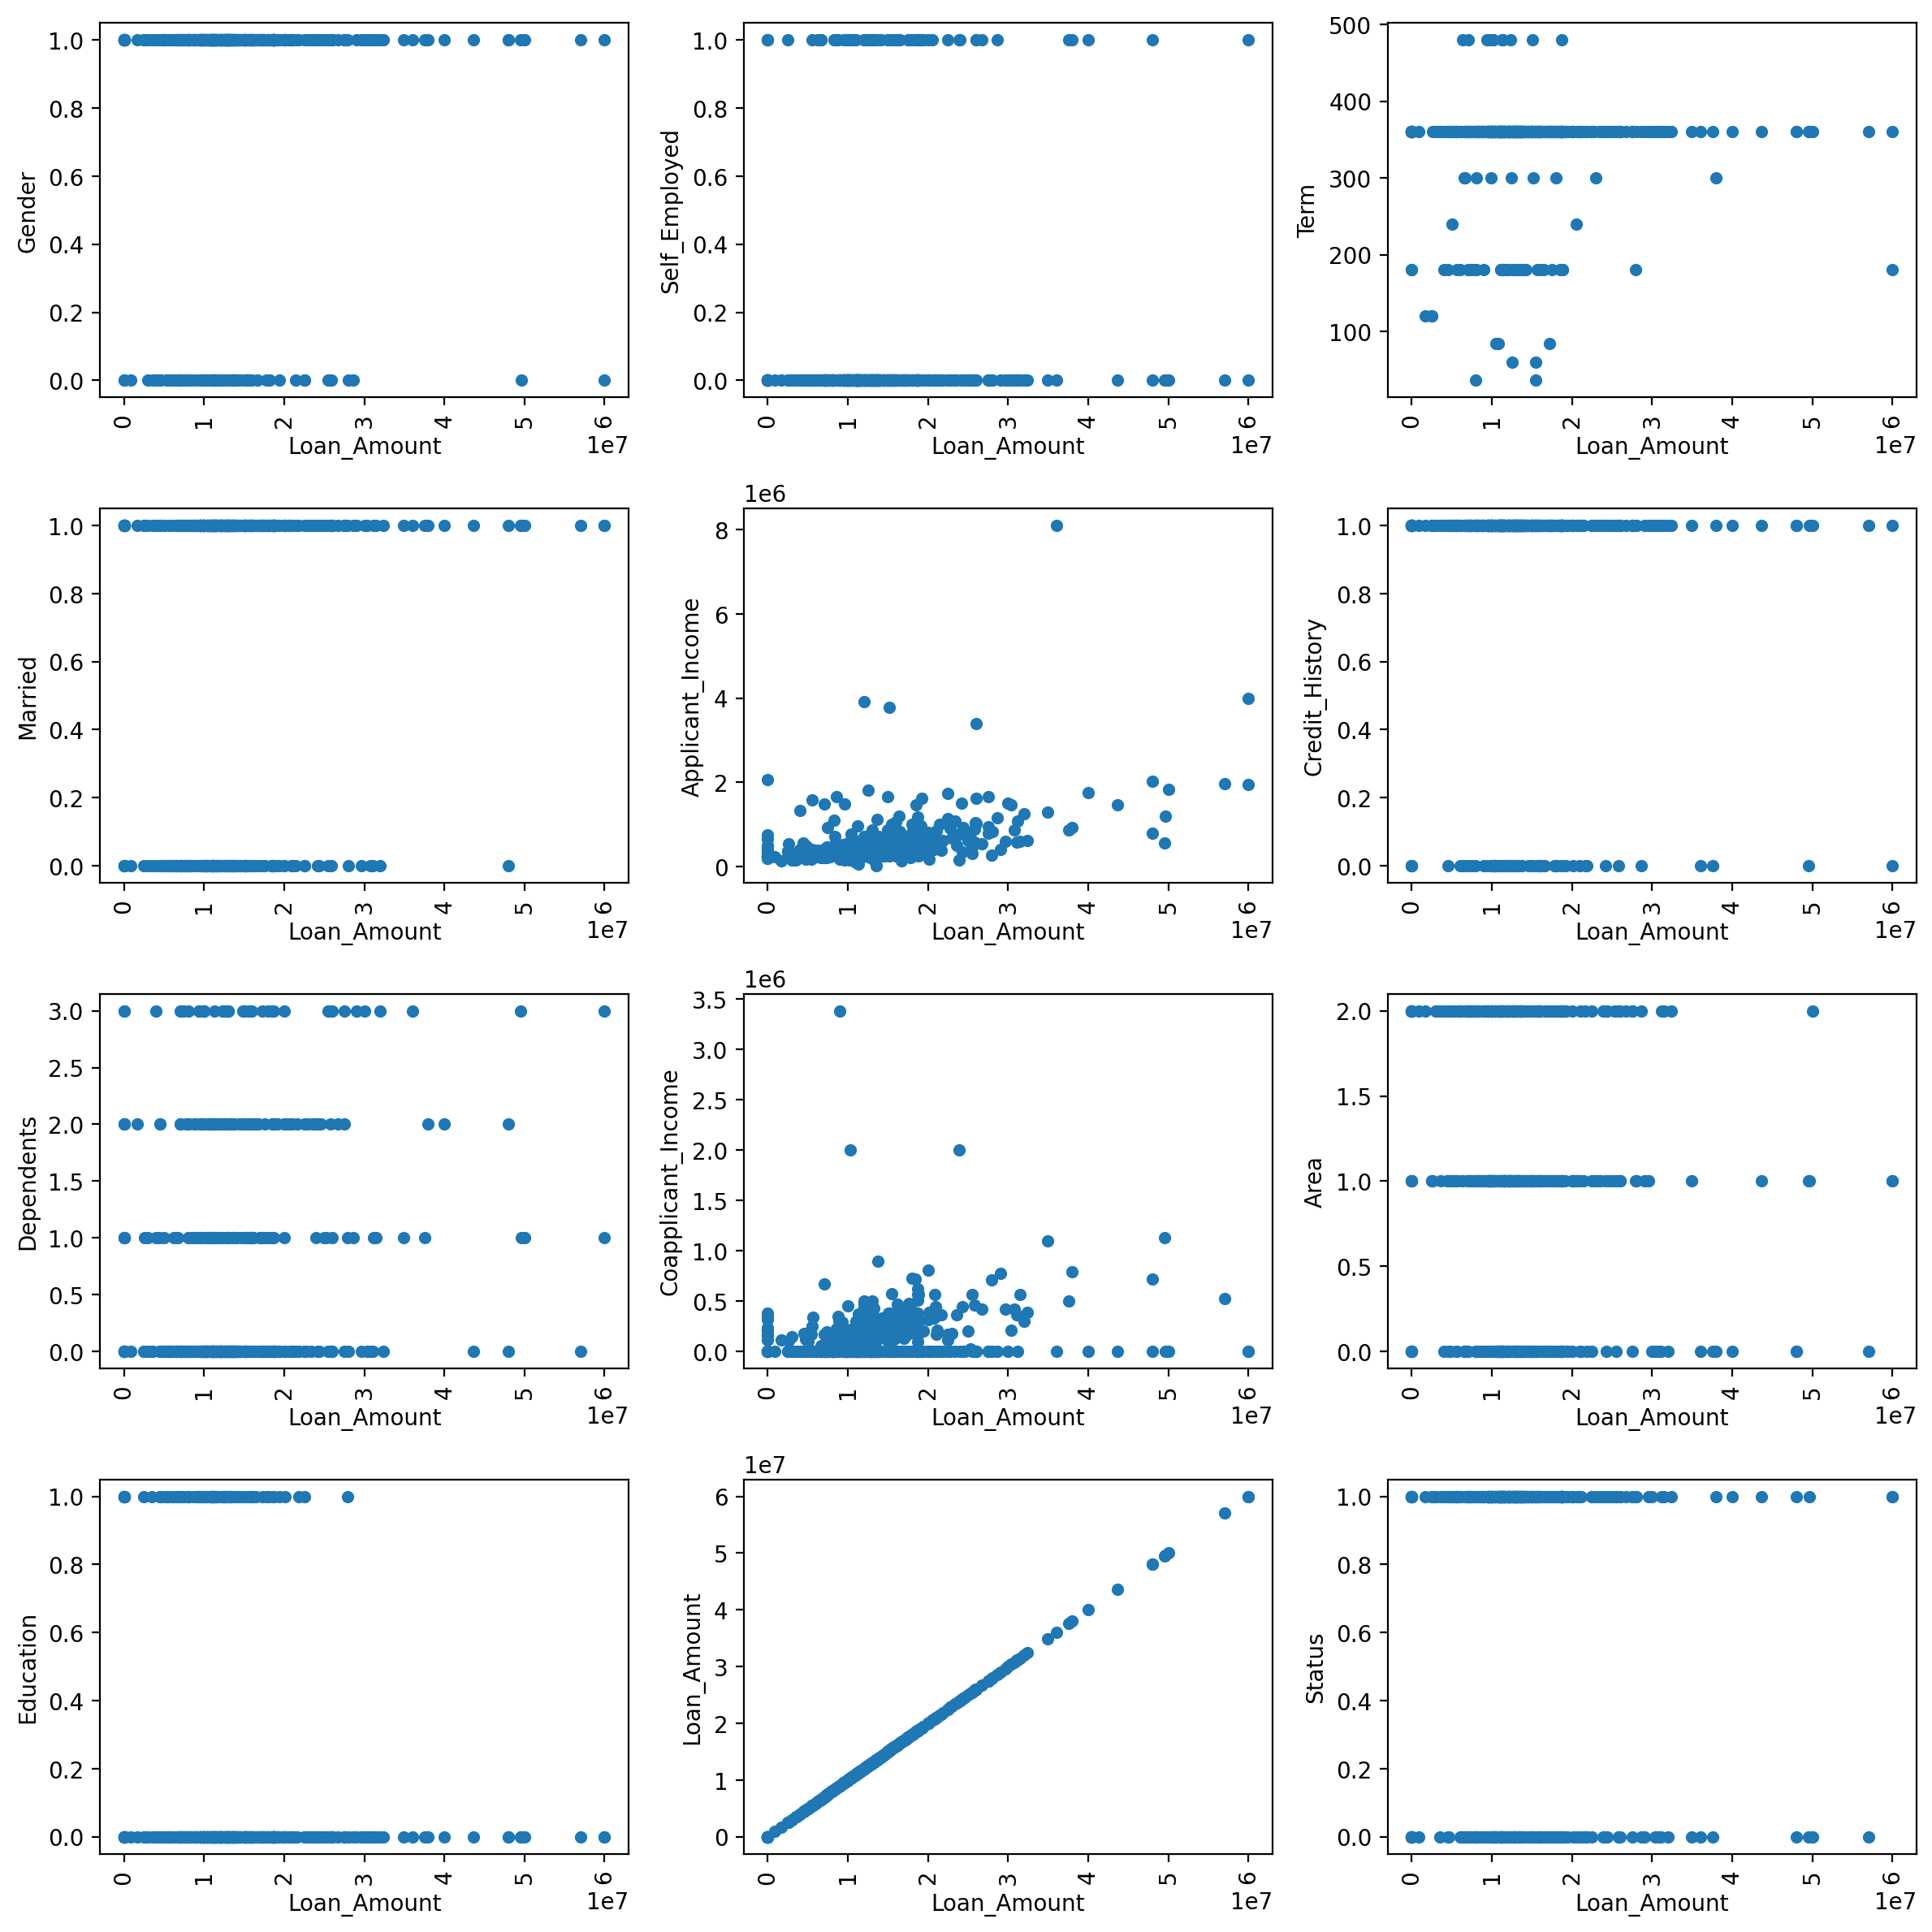

In [105]:
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=4, dpi=200)
for i, f in enumerate(df):
    df.plot("Loan_Amount", f, subplots=True, kind='scatter', ax = axes[i%4, i//4])
    axes[i%4, i//4].tick_params(axis='x', labelrotation=90)
plt.tight_layout()

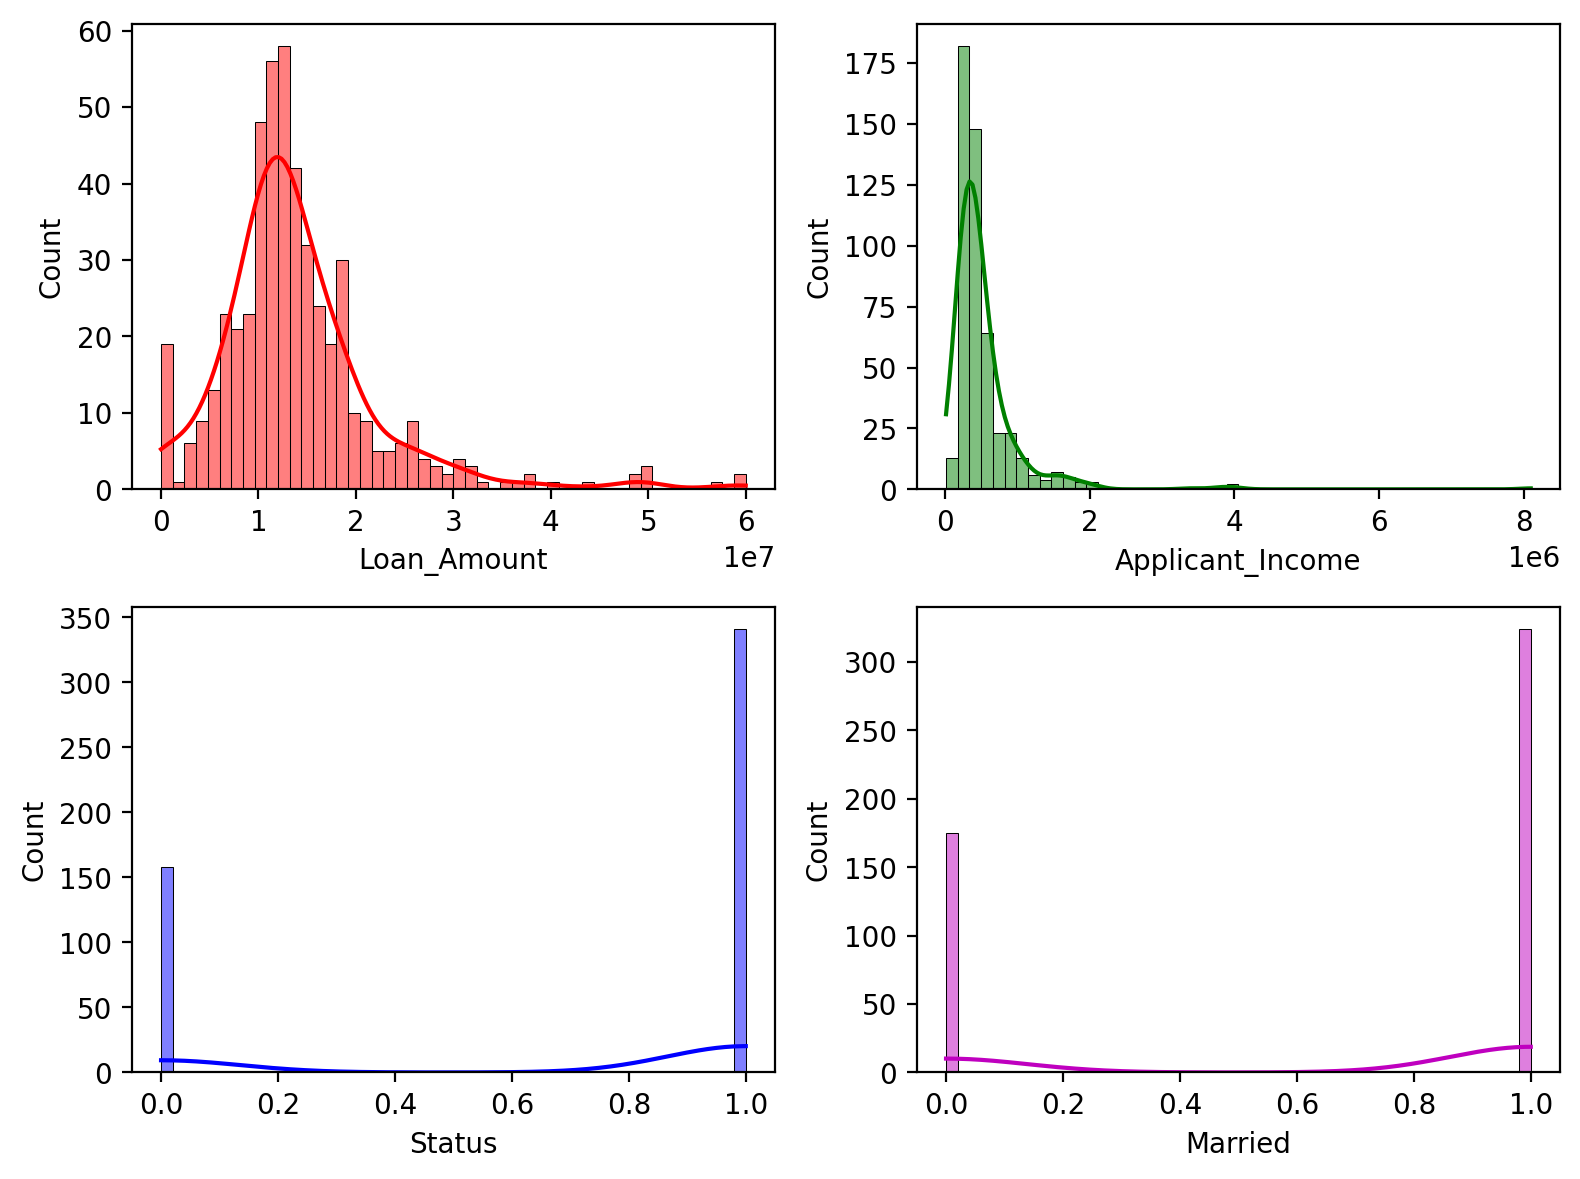

In [106]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), dpi=200)
sns.histplot(df["Loan_Amount"], bins=50, kde=True, color='r', ax=axes[0,0])
sns.histplot(df["Applicant_Income"], bins=50, kde=True, color='g', ax=axes[0,1])
sns.histplot((df["Status"]), bins=50, kde=True, color='b', ax=axes[1,0])
sns.histplot((df["Married"]), bins=50, kde=True, color='m', ax=axes[1,1])
# axes[1,0].set_xlabel("High-Low")
# axes[1,1].set_xlabel("Open-Close")
plt.tight_layout()

In [107]:
df.isna().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Term                  0
Credit_History        0
Area                  0
Status                0
dtype: int64

<Axes: >

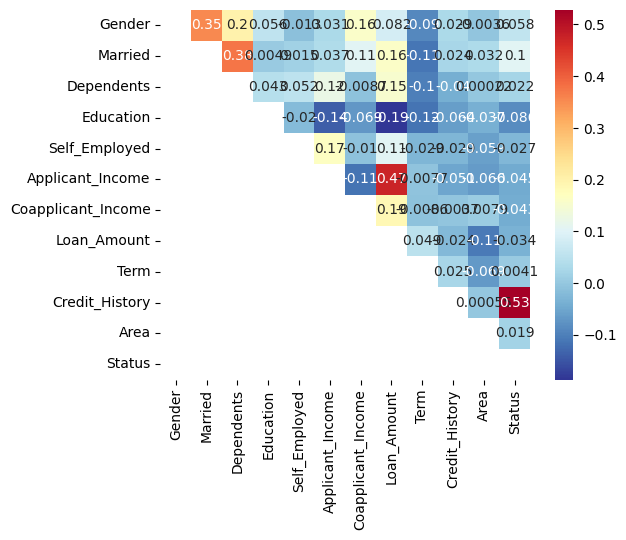

In [108]:
corrs = df.corr()
corrs = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
sns.heatmap(corrs, cmap="RdYlBu_r",  square=True, annot=True)

Выводы по эксплоритарному анализу: не было обнаружено каких либо корелляций. У разниц у спредов (High_Low) и (Open_close), а также объем торгов имееют стандартное распределение.

## Задание 1.3

Построить и оценить качество бейзлайна

Комментарий: В рамках данного пункта необходимо выбрать и обучить бейзлайн-модель, а также измерить ее качество.

Критерии оценки:

- Произведено измерение качества константного предсказания (например, наиболее частотный класс для классификации, среднее/медиана для регрессии) - 3 балла
- Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть - 5 балла
- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - 2 балла
- Продемонстрировать использование библиотеки plotly для визуализации

Ответ:

Далее рассмотрим только столбцы Data и Open, так как остальные столбцы коррелируют между собой.

Для разбеения выборки на тренеровочный и тестовй применялася TimeSeriesSplit 

In [109]:
X, y = df.drop(columns='Status'), df["Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)

# t_split = TimeSeriesSplit(n_splits=2)|


<Axes: ylabel='Density'>

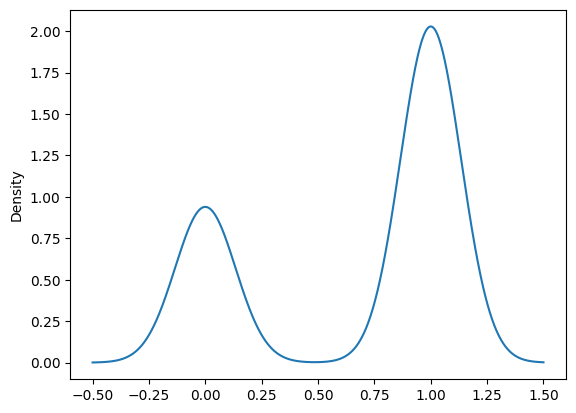

In [110]:
y.plot(kind='kde')

In [120]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

In [121]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

In [122]:
print(f'MSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy)}')
print(f'MSE for Linear regression: {mean_squared_error(y_test, y_preds_lr)}')

MSE for Dummy Regressor: 0.304
MSE for Linear regression: 0.1643065575610142


In [123]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 0.5513619500836089
RMSE for Linear regression: 0.4053474528858103


In [124]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

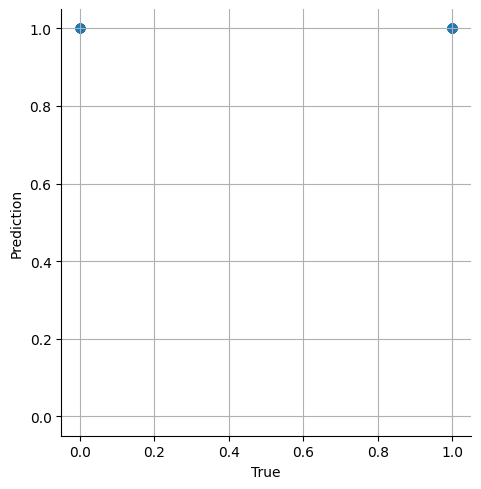

In [125]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')

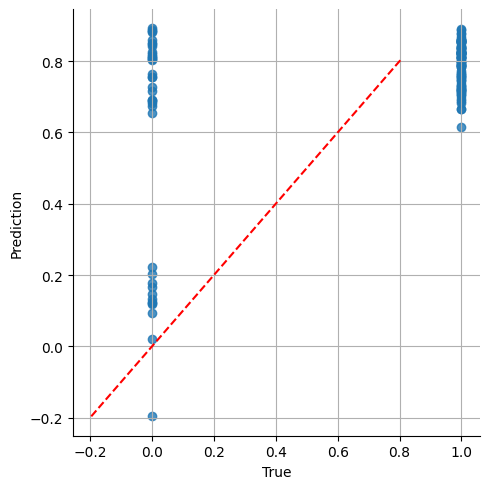

In [126]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

In [115]:
print(f'MAE for Dummy Regressor: {mean_absolute_error(y_test, y_preds_dummy)}')
print(f'MAE for Linear regression: {mean_absolute_error(y_test, y_preds_lr)}')

MAE for Dummy Regressor: 98.82007168458784
MAE for Linear regression: 372.8551211988262


In [116]:
print(f'MAPE for Dummy Regressor: {mean_absolute_percentage_error(y_test, y_preds_dummy)}')
print(f'MAPE for Linear regression: {mean_absolute_percentage_error(y_test, y_preds_lr)}')

MAPE for Dummy Regressor: 0.08435147227581896
MAPE for Linear regression: 0.3006275061682225


In [117]:
print(f'R2 score for Dummy Regressor: {r2_score(y_test, y_preds_dummy)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')

R2 score for Dummy Regressor: -1.6262315288619633
R2 score for Linear regression: -30.342280982632243


Выводы по Задаче 1.3: рассмотренные модели показали давольно низкую сходимость результатов. Для выбранного датасета требуется более глубокое обучение